# Init

## load modules

In [41]:
import os
import sys

    
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from PIL import Image, ImageDraw

import radii as radi
import numpy as np
import SimpleITK as sitk
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import Interface as I
from getting_started import getting_started_dir

#%matplotlib inline

## draw_line()

In [42]:
def draw_line_from_point_to_point(draw, p1, p2):
    draw.line((p1[0], p1[1], p2[0], p2[1]),fill=(255,101,80,40), width=2)

def drawLine(image, rays):
    
    im = Image.open(image).convert("RGBA")
    draw = ImageDraw.Draw(im) 
 
    #draw.line((backCounterPoint[0], backCounterPoint[1], frontCounterPoint[0], frontCounterPoint[1]), fill=200, width=5)
    for rayIndex, ray in enumerate(rays):
        p1 = np.array(ray[0])
        p2 = np.array(ray[-1])
        v = p2-p1
        center = v/2.0
        p11 = p1+0.45*v
        p12 = p1+0.55*v
        
        draw.text((0,0),"lines next to the numbers are showing front rays",fill=(255,255,255,128))
        draw.text((ray[-1][0], ray[-1][1]),str(rayIndex),fill=(255,255,255,128))
        #draw.line((ray[0][0], ray[0][1], ray[-1][0], ray[-1][1]),fill=(255,101,80,1), width=2)
        draw_line_from_point_to_point(draw, p1, p11)
        draw_line_from_point_to_point(draw, p12, p2)
        #draw.line((center[0], ray[0][1], ray[-1][0], ray[-1][1]),fill=(255,101,80,1), width=2)
        #draw.line((ray[0][0], ray[0][1], ray[-1][0], ray[-1][1]),fill=(255,101,80,1), width=2)
    im.show()

    #im.save(sys.stdout, "PNG")
    

## plotCircularProfiles()

In [43]:
def plotCircularProfiles(raysProfileList, selectedProfileIndex):
    

 #   t1 = np.arange(0.0, 5.0, 0.1)
    length = len(raysProfileList)
    #plt.figure(1)
    plt.figure(figsize=(10,18))
    
    for rayIndex, ray in enumerate(raysProfileList[0:length]):
        l = len(ray)*0.092
        x = np.arange(-l/2.0, l/2.0, 0.092)
        plt.subplot(len(raysProfileList),1, rayIndex+1)
        
        #plt.subplot(len(raysProfileList),1, rayIndex+1, frameon=False)
        #plt.axis('off')  
        plt.plot(x,ray,label=str(rayIndex), c = 'r' if rayIndex == selectedProfileIndex else 'k')
        assert(len(ray) % 2 == 1)
        id_mid_point = int((len(ray)-1)/2)
        plt.plot(0, ray[id_mid_point], "o")
        plt.legend()
        plt.tight_layout()
    plt.show() 


## statistics()

In [44]:
def statistics(pos):
    rays, raysProfiles = radiusCalculator.getProfileAtThisPoint(inputImage_s13, pos)
    
    selectedBackProfile, selectedFrontProfile, radiusList,\
    minRadius, BackCountorPoint, frontCounterPoint,\
    counterList,raysProfiles_1, rays, selectedProfileIndex = radiusCalculator.getRadiusFromProfile(inputImage_s13, pos)
    
    drawLine(inputTifImage_s13, rays)
    print 'minRadius: ', minRadius 
    plotCircularProfiles(raysProfiles, selectedProfileIndex)

## collectRadii()

In [45]:
def collectRadii(points, cutOffValues, numberOfRays, postMeasurment='no'): 
    radiiSet = []
    for cutOff in cutOffValues:
       
        radiusCalculator = radi.calcRad.RadiusCalculator(xyResolution=0.092,
                                                 zResolution=0.5,
                                                 xySize=20,
                                                 numberOfRays=numberOfRays,
                                                 tresholdPercentage=cutOff)
        radii = radiusCalculator.getProfileOfThesePoints(inputImage_s13, points, postMeasurment)
         
        radiiSet.append(radii)
        del radiusCalculator
    return radiiSet


## scatterPlot()

In [46]:
def scatterPlot(radiiData, style = 'scatter'):

    g1 = radiiData[0]
    g2 = radiiData[1]
    g3 = radiiData[2]
    
    gLen = len(g1)
    area = 30
    
    data = (g1, g2, g3)
    colors = ("red", "green", "blue")
    groups = ("0.25", "0.5", "0.75")
     
   
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
 
    for data, color, group in zip(data, colors, groups):
        x = np.arange(0, gLen, 1)
        y = data
        if style == 'scatter':
            ax.scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=area, label=group)
        elif style == 'line':
            ax.plot(x, y, c=color, label=group)


    plt.title('radius scatter plot')
    plt.legend(loc=2)
    plt.savefig('scatter.png', bbox_inches='tight')
    plt.show()

## optional: switches on clicking mode

# Load Data

## Setup ModelDataBase

In [77]:
mdb = I.ModelDataBase('/nas1/Data_anajafgholi/results/20190410_profiling')

## Full structure

In [217]:
inputTifImage_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/tif/max_z_projections','S13_max_z_projection.tif')
inputAmData_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am','S13_final_done_Alison_zScale_40.am')
outputAmData025_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am_output','S13_withRadius025.am')
outputAmData05_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am_output','S13_withRadius05.am')
outputAmData075_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am_output','S13_withRadius075.am')

In [79]:
imageFileReader = sitk.ImageFileReader()
imageFileReader.SetFileName(inputTifImage_s13)
inputImage_s13 = imageFileReader.Execute()

## Axon only

In [80]:
inputTifImageAxon_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/tif/max_z_projections','S13_max_z_projection.tif')
inputAmDataAxon_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am_analysis','S13_final_done_Alison_zScale_40_axon.am')

In [81]:
imageFileAxonReader = sitk.ImageFileReader()
imageFileAxonReader.SetFileName(inputTifImageAxon_s13)
inputImageAxon_s13 = imageFileAxonReader.Execute()

## Dendrite only

In [96]:
inputTifImageDendrite_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/tif/max_z_projections','S13_max_z_projection.tif')
inputAmDataDendrite_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am_analysis','S13_final_done_Alison_zScale_40_dendrite.am')

In [97]:
imageFileDendriteReader = sitk.ImageFileReader()
imageFileDendriteReader.SetFileName(inputTifImageDendrite_s13)
inputImageDendrite_s13 = imageFileDendriteReader.Execute()

# Get spatial points

## Full structure - Spatial Points

In [98]:
points = radi.spacialGraph.getSpatialGraphPoints(inputAmData_s13)
points = mdb.maybe_calculate('points', lambda: map(lambda x: map(lambda y: int(y/0.092), x), points))
radiiSet = mdb.maybe_calculate('radiiSet', lambda: collectRadii(points, [0.25, 0.5, 0.75], 10))

In [189]:
def get_modified_points(points):
    radiusCalculator = radi.calcRad.RadiusCalculator(xyResolution=0.092,
                                                 zResolution=0.5,
                                                 xySize=20,
                                                 numberOfRays=20,
                                                 tresholdPercentage=0.5)

    radiusCalculator.debug_postMeasurementPoints = []
    radiusCalculator.getProfileOfThesePoints(inputImage_s13, points, 'yes')
    return radiusCalculator.debug_postMeasurementPoints

In [191]:
modified_points = get_modified_points(points)

In [163]:
intensity_at_point = [inputImage_s13.GetPixel(point) for point in points]

In [204]:
intensity_at_modified_points = [inputImage_s13.GetPixel(point) for point in modified_points]

## Axon - Spatial Points

In [99]:
points_axon = radi.spacialGraph.getSpatialGraphPoints(inputAmDataAxon_s13)
points_axon = mdb.maybe_calculate('points_axon', lambda: map(lambda x: map(lambda y: int(y/0.092), x), points_axon))
radiiSetAxon = mdb.maybe_calculate('radiiSet_axon', lambda: collectRadii(points_axon, [0.25, 0.5, 0.75], 10))

In [165]:
intensity_at_point_axon = [inputImageAxon_s13.GetPixel(point) for point in points_axon]

In [195]:
modified_axonPoints = get_modified_points(points_axon)

In [198]:
intensity_at_modified_axon_points = [inputImageAxon_s13.GetPixel(point) for point in modified_axonPoints]

## Dendrite - Spatial Points

In [101]:
points_dendrite = radi.spacialGraph.getSpatialGraphPoints(inputAmDataDendrite_s13)
points_dendrite = mdb.maybe_calculate('points_dendrite', lambda: map(lambda x: map(lambda y: int(y/0.092), x), points_dendrite))
radiiSetDendrite = mdb.maybe_calculate('radiiSet_dendrite', lambda: collectRadii(points_dendrite, [0.25, 0.5, 0.75], 10))

In [166]:
intensity_at_point_dendrite = [inputImageAxon_s13.GetPixel(point) for point in points_dendrite]

In [196]:
modified_dendritePoints = get_modified_points(points_dendrite)

In [197]:
intensity_at_modified_dendrite_points = [inputImageAxon_s13.GetPixel(point) for point in modified_dendritePoints]

# Extract radii

## Full structure

### Full structure - first measurment

In [102]:
#temp = collectRadii(points, [0.25, 0.5, 0.75], 10, 'no')

In [103]:
#mdb['radiiSet'] = temp

In [104]:
radiiSet = mdb.maybe_calculate('radiiSet', lambda: collectRadii(points, [0.25, 0.5, 0.75], 10, 'no'))

### Full structue - post Measurment

In [105]:
temp_post = collectRadii(points, [0.25, 0.5, 0.75], 10, 'yes')

In [106]:
mdb['postRadiiSet'] = temp_post

In [107]:
postRadiiSet = mdb.maybe_calculate('postRadiiSet', lambda: collectRadii(points, [0.25, 0.5, 0.75], 10, 'yes'))

In [187]:
radiusCalculator = radi.calcRad.RadiusCalculator(xyResolution=0.092,
                                                 zResolution=0.5,
                                                 xySize=20,
                                                 numberOfRays=20,
                                                 tresholdPercentage=0.5)

radiusCalculator.debug_postMeasurementPoints = []

## Axon Only

### Axon only - first measurment

In [108]:
#temp_axon = collectRadii(points_axon, [0.25, 0.5, 0.75], 10, 'no')

In [109]:
#mdb['radiiSetAxon'] = temp_axon

In [110]:
postRadiiSetAxon = mdb.maybe_calculate('radiiSetAxon', lambda: collectRadii(points_axon, [0.25, 0.5, 0.75], 10, 'no'))

### Axon only - post measurment

In [111]:
#tempPost_axon = collectRadii(points_axon, [0.25, 0.5, 0.75], 10, 'yes')

In [112]:
#mdb['postRadiiSetAxon'] = tempPost_axon

In [113]:
postRadiiSetAxon = mdb.maybe_calculate('postRadiiSetAxon', lambda: collectRadii(points_axon, [0.25, 0.5, 0.75], 10, 'yes'))

## Dendrite only

### Dendrite only - first measurment

In [114]:
#temp_dendrite = collectRadii(points_dendrite, [0.25, 0.5, 0.75], 10, 'no')

In [115]:
#mdb['radiiSetDendrite'] = temp_dendrite

In [121]:
radiiSetDendrite = mdb.maybe_calculate('radiiSetDendrite', lambda: collectRadii(points_dendrite, [0.25, 0.5, 0.75], 10, 'no'))

### Dendrite only - post measurment

In [117]:
#tempPost_dendrite = collectRadii(points_dendrite, [0.25, 0.5, 0.75], 10, 'yes')

In [118]:
#mdb['postRadiiSetDendrite'] = tempPost_dendrite

In [122]:
postRadiiSetDendrite = mdb.maybe_calculate('postRadiiSetDendrite', lambda: collectRadii(points_dendrite, [0.25, 0.5, 0.75], 10, 'yes'))

# Analysis

In [ ]:
radiusCalculator = radi.calcRad.RadiusCalculator(xyResolution=0.092,
                                         zResolution=0.5,
                                         xySize=20,
                                         numberOfRays=10,
                                         tresholdPercentage=0.5)

In [ ]:
[points[idx] for idx, p in enumerate(postRadiiSet[0]) if p == 100]

### debugging: how does a single point get updated?

In [ ]:
point_original = [201, 558] # [195, 560, 0] # [2740, 568, 227]
_, _, _, _, _, _, _, raysProfileList, rays, _ = radiusCalculator.getRadiusFromProfile(inputImage_s13, point_original, postMeasurment='no')

In [ ]:
point_original = [195, 560, 0]

In [ ]:
point_modified = radiusCalculator.postMeasurmentFunction(inputImage_s13, rays, raysProfileList)
_, _, _, radius, _, _, _, _, _, _ = radiusCalculator.getRadiusFromProfile(inputImage_s13, point_modified, postMeasurment='no')

In [ ]:
intensity_at_point = [inputImage_s13.GetPixel(point) for point in points]

In [ ]:
radius*0.092

In [ ]:
print point_original
print point_modified

In [ ]:
statistics(point_original)

In [ ]:
statistics(point_modified)

In [ ]:
statistics([2740, 568, 227])

In [ ]:
pdf = I.pd.DataFrame(radiiSet).T*0.092

In [221]:
ppdf = I.pd.DataFrame(postRadiiSet).T*0.092

## dark point on axon, sligthly beside structure

In [ ]:
radiusCalculator.tresholdPercentage = 0.8

In [ ]:
statistics([2740, 568, 227])

In [ ]:
statistics(point)

## bla

In [ ]:
statistics([1309, 407, 142])

# Intensity Distribution Structure vs. Background

In [169]:
def get_random_point(image, n):
    dim = image.GetSize()
    intensities = []
    for n in range(n):
        point = [I.np.random.randint(0, dim[0]), I.np.random.randint(0, dim[1])]
        intensities.append(image.GetPixel(point))
    return intensities

## Full structure - First Measurment

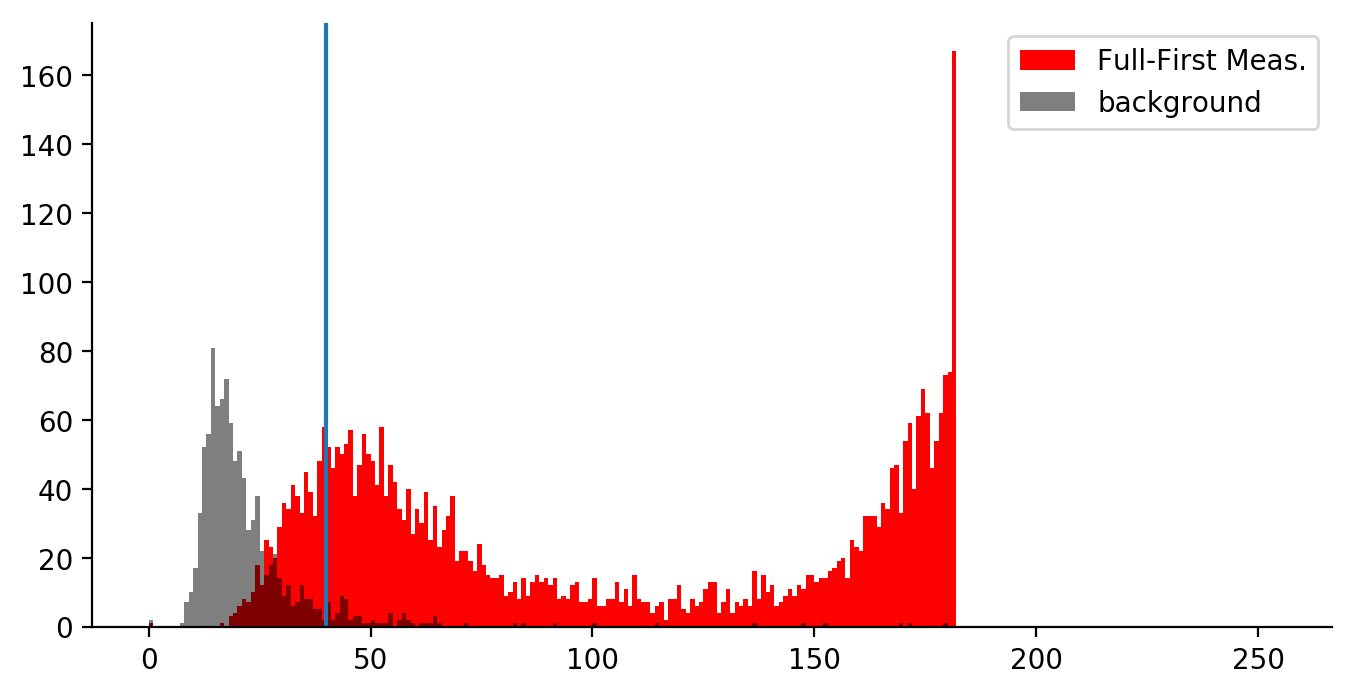

In [206]:
I.plt.figure(figsize = (8,4), dpi = 200)
bins = I.np.arange(0,255)
_ = I.plt.hist(intensity_at_point, bins = bins, label = 'Full-First Meas.', color = 'r')
_ = I.plt.hist(get_random_point(inputImage_s13, 1000), bins = bins, label = 'background', color = 'k', alpha = .5)
I.plt.legend()
I.plt.axvline(40)
I.sns.despine()


## Full structure - Post Measurment

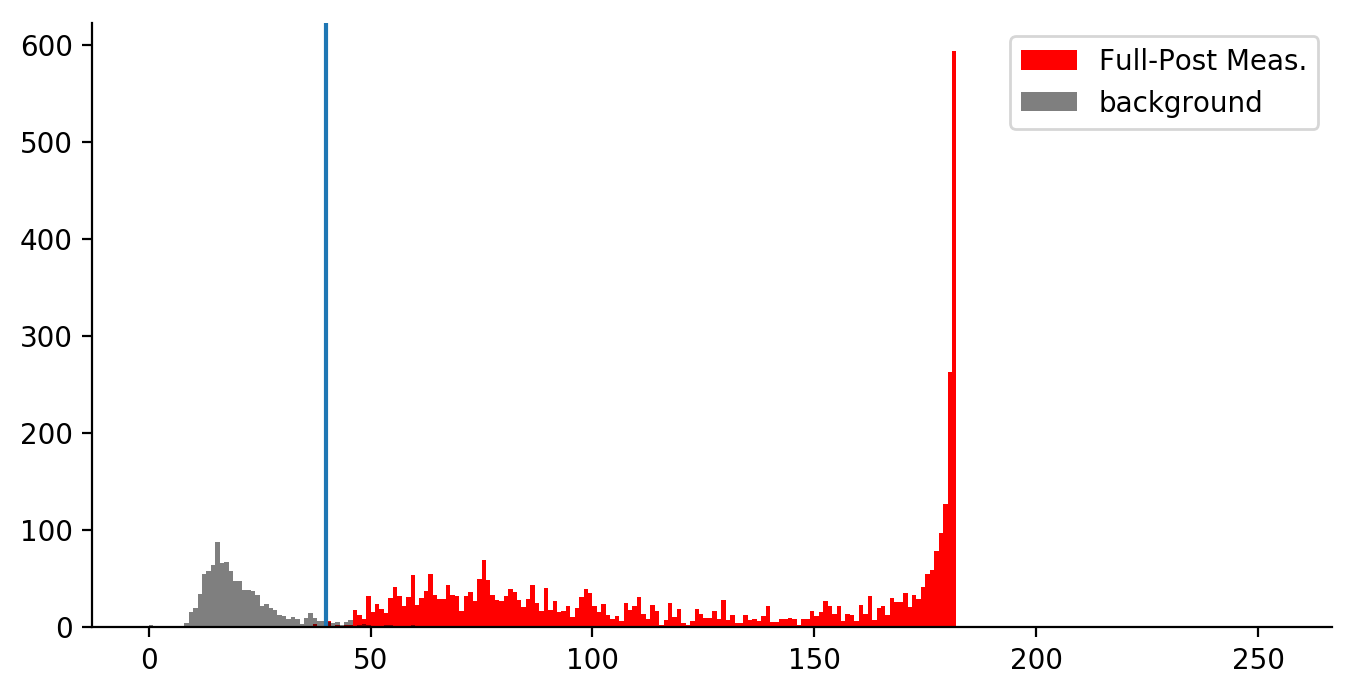

In [207]:
I.plt.figure(figsize = (8,4), dpi = 200)
bins = I.np.arange(0,255)
_ = I.plt.hist(intensity_at_modified_points, bins = bins, label = 'Full-Post Meas.', color = 'r')
_ = I.plt.hist(get_random_point(inputImage_s13, 1000), bins = bins, label = 'background', color = 'k', alpha = .5)
I.plt.legend()
I.plt.axvline(40)
I.sns.despine()


## Axon vs. Background - First Measurment

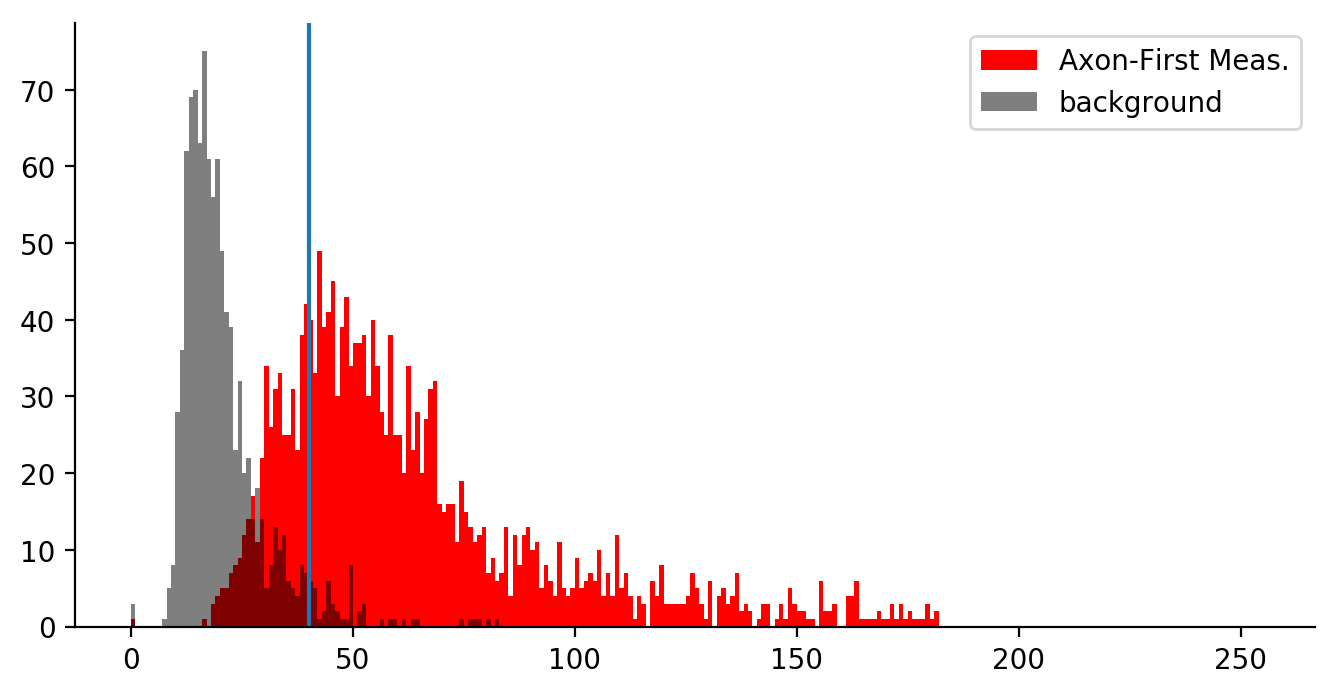

In [209]:
I.plt.figure(figsize = (8,4), dpi = 200)
bins = I.np.arange(0,255)
_ = I.plt.hist(intensity_at_point_axon, bins = bins, label = 'Axon-First Meas.', color = 'r')
_ = I.plt.hist(get_random_point(inputImage_s13, 1000), bins = bins, label = 'background', color = 'k', alpha = .5)
I.plt.legend()
I.plt.axvline(40)
I.sns.despine()


## Axon vs. Background - Post Measurment

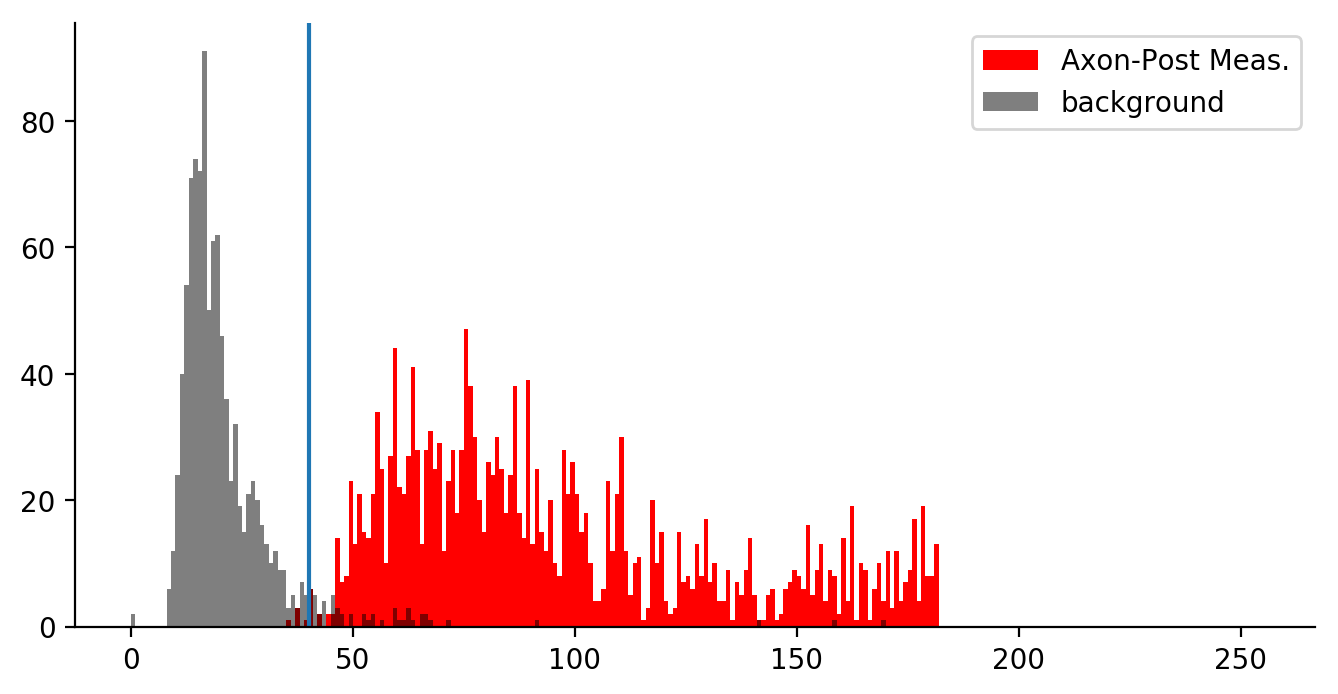

In [210]:
I.plt.figure(figsize = (8,4), dpi = 200)
bins = I.np.arange(0,255)
_ = I.plt.hist(intensity_at_modified_axon_points, bins = bins, label = 'Axon-Post Meas.', color = 'r')
_ = I.plt.hist(get_random_point(inputImage_s13, 1000), bins = bins, label = 'background', color = 'k', alpha = .5)
I.plt.legend()
I.plt.axvline(40)
I.sns.despine()


## Dendrite vs. Background - First Measurment

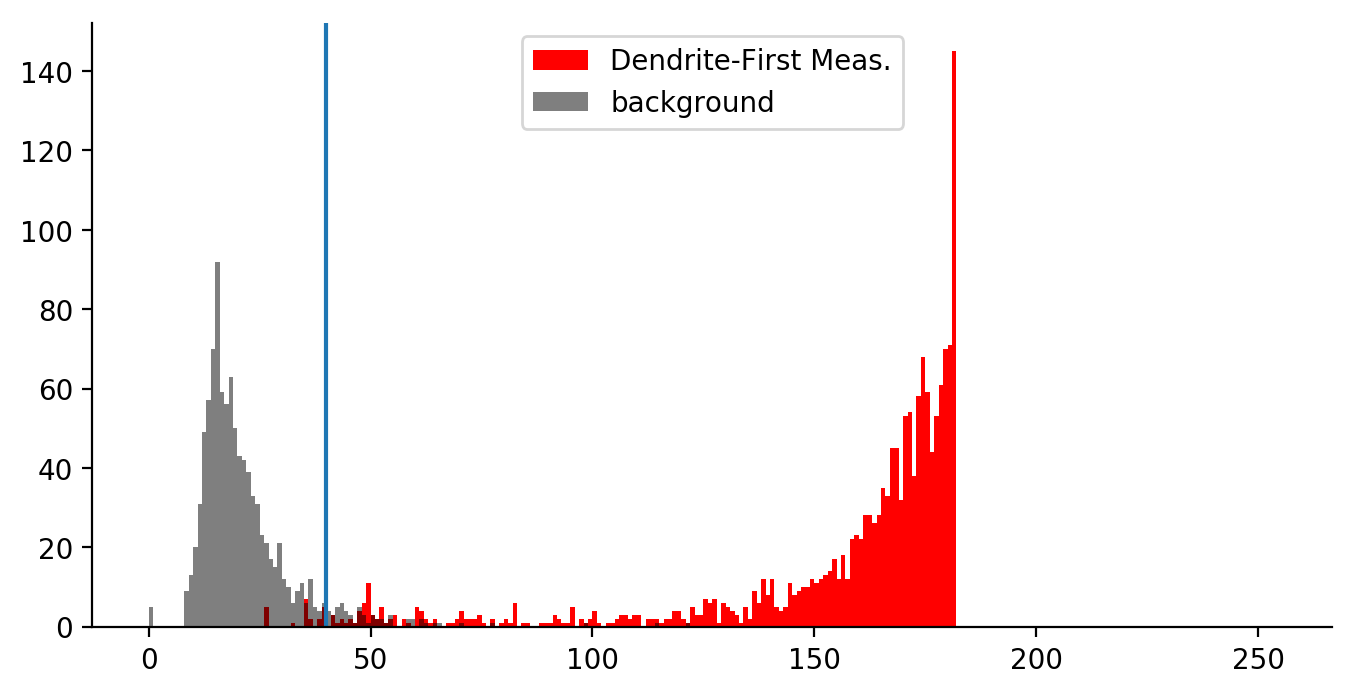

In [211]:
I.plt.figure(figsize = (8,4), dpi = 200)
bins = I.np.arange(0,255)
_ = I.plt.hist(intensity_at_point_dendrite, bins = bins, label = 'Dendrite-First Meas.', color = 'r')
_ = I.plt.hist(get_random_point(inputImage_s13, 1000), bins = bins, label = 'background', color = 'k', alpha = .5)
I.plt.legend()
I.plt.axvline(40)
I.sns.despine()


## Dendrite vs. Background - Post measurment

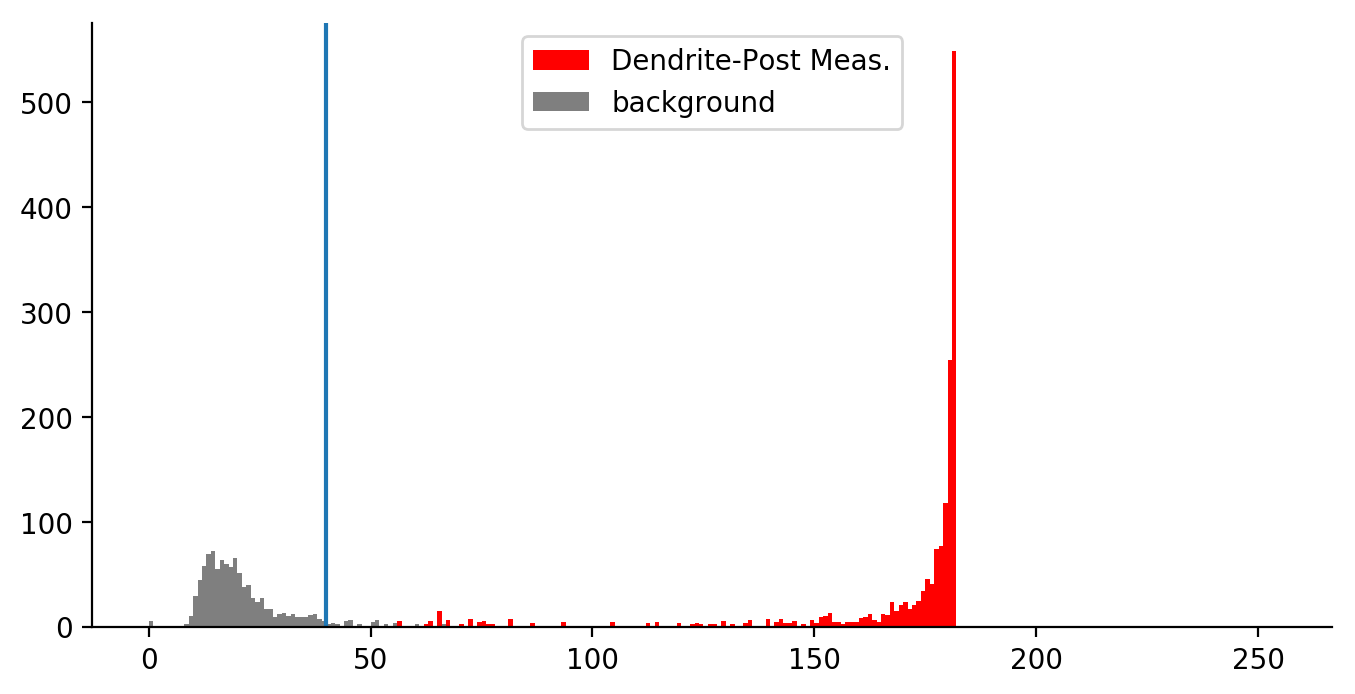

In [212]:
I.plt.figure(figsize = (8,4), dpi = 200)
bins = I.np.arange(0,255)
_ = I.plt.hist(intensity_at_modified_dendrite_points, bins = bins, label = 'Dendrite-Post Meas.', color = 'r')
_ = I.plt.hist(get_random_point(inputImage_s13, 1000), bins = bins, label = 'background', color = 'k', alpha = .5)
I.plt.legend()
I.plt.axvline(40)
I.sns.despine()


# ScatterPlot

## Full Structure - First Measurment

/home/amir/Projects/in_silico_framework_env/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


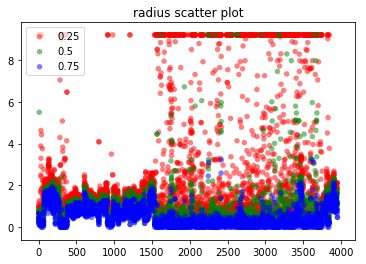

In [123]:
scatterPlot(map(lambda x: I.np.array(x)*0.092, radiiSet))

## Full Structure - Post Measurment

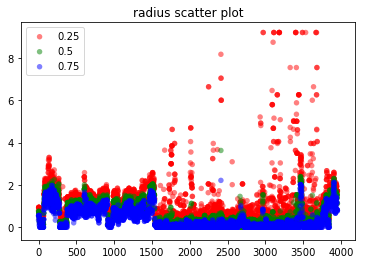

In [125]:
scatterPlot(map(lambda x: I.np.array(x)*0.092, postRadiiSet))

## Axon - First Measurment

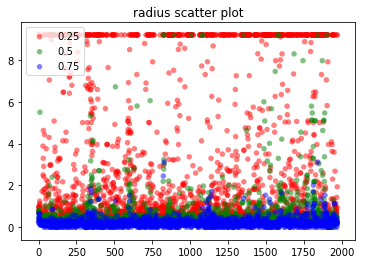

In [131]:
scatterPlot(map(lambda x: I.np.array(x)*0.092, radiiSetAxon))

## Axon - Post Measurment

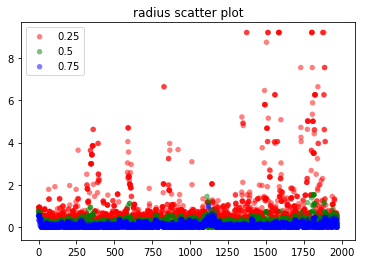

In [132]:
scatterPlot(map(lambda x: I.np.array(x)*0.092, postRadiiSetAxon))

## Dendrite - First Measurment

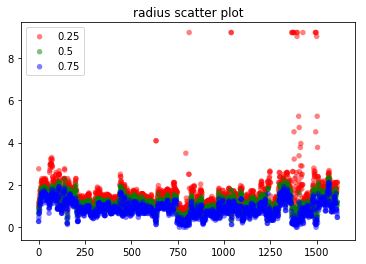

In [133]:
scatterPlot(map(lambda x: I.np.array(x)*0.092, radiiSetDendrite))

## Dendrite - Post Measurment

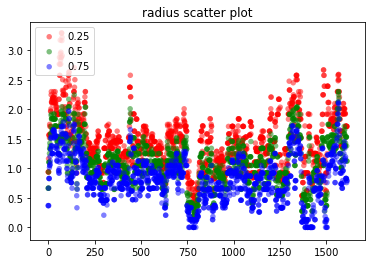

In [135]:
scatterPlot(map(lambda x: I.np.array(x)*0.092, postRadiiSetDendrite))

## scatterplot of bright (>100) structure

In [141]:
pdf = I.pd.DataFrame(radiiSet).T*0.092

In [142]:
pdf['intensity'] = intensity_at_point

In [143]:
selected_pdf = pdf[pdf.intensity > 45]

In [144]:
radiiSet_selected = map(lambda columnname: list(selected_pdf[columnname]), [0,1,2])

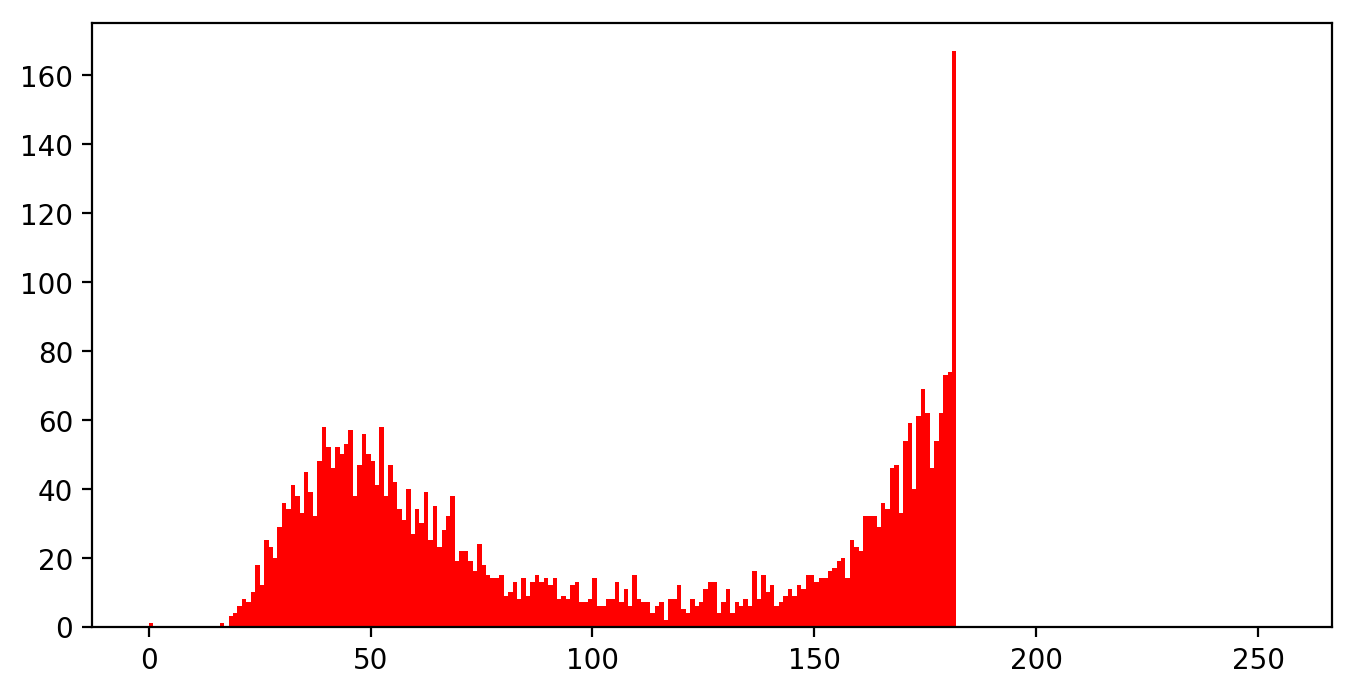

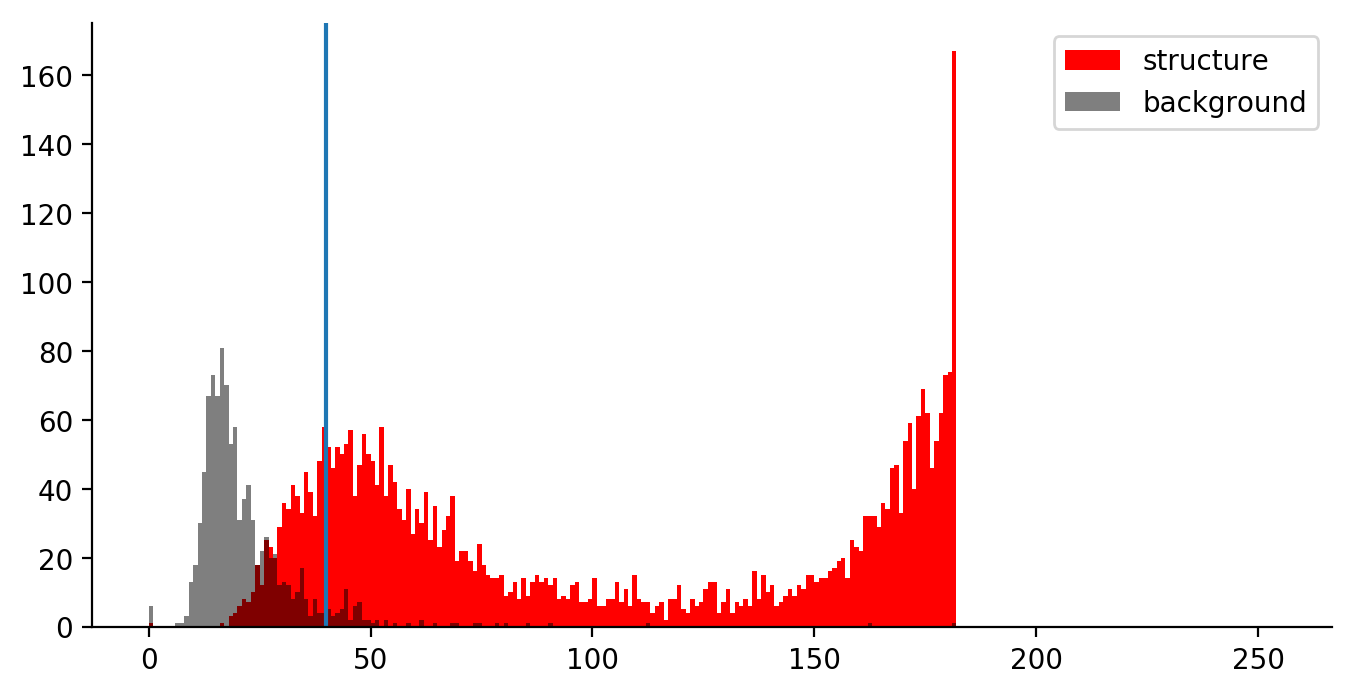

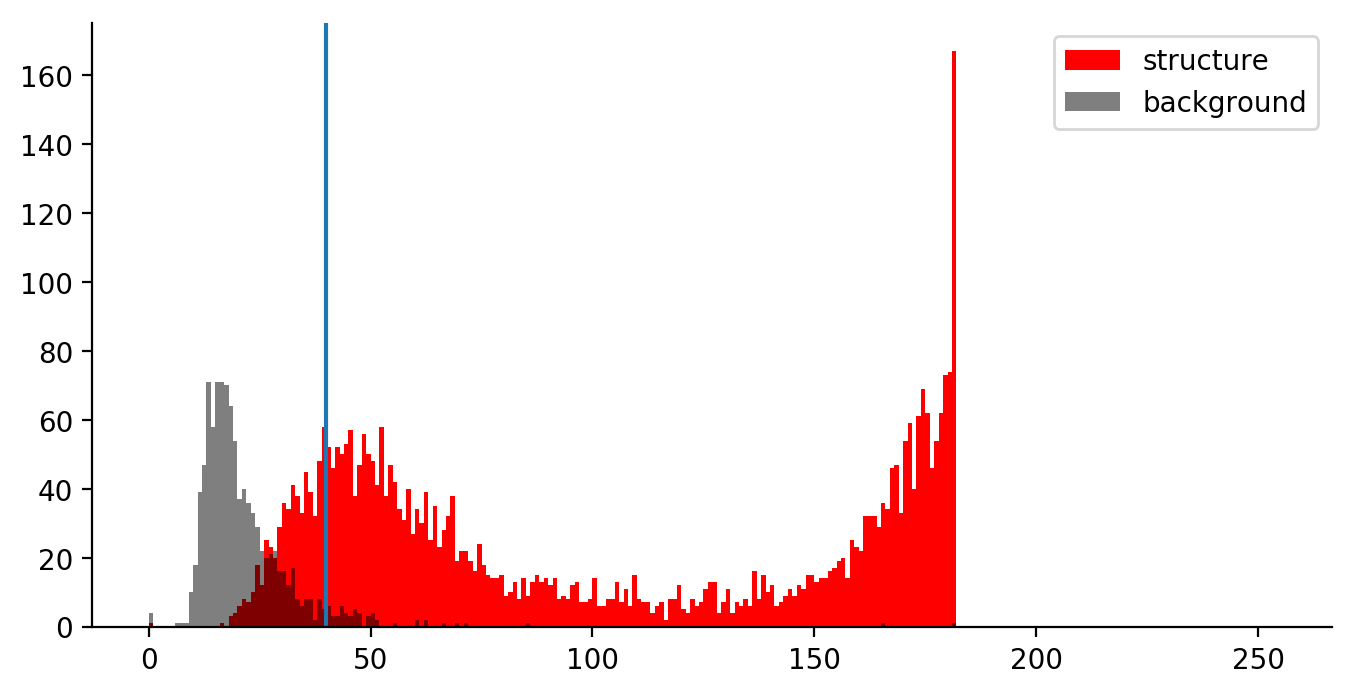

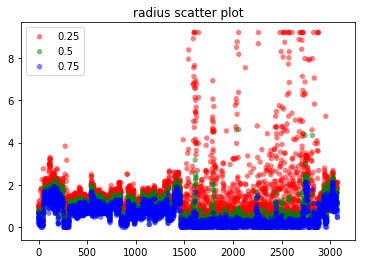

In [145]:
scatterPlot(radiiSet_selected)

# PDF

In [226]:
## Pdf - Post

In [224]:
ppdf['intensity'] = intensity_at_modified_points

In [262]:
def error_vs_success_rate(ppdf):
    ppdf['error'] = ppdf[0] - ppdf[2]
    _ = I.plt.hist(ppdf.error, bins = I.np.arange(0, 8, .01), cumulative = True, normed = True)
    I.sns.despine()
    I.plt.xlabel('error / micron')
    I.plt.ylabel('frac. successful radius estimates')

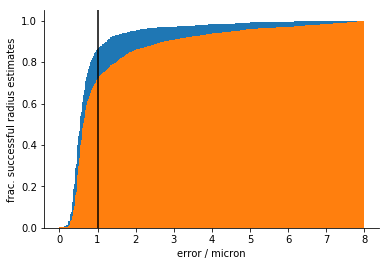

In [263]:
error_vs_success_rate(ppdf)
error_vs_success_rate(pdf)
I.plt.axvline(1, c = 'k')

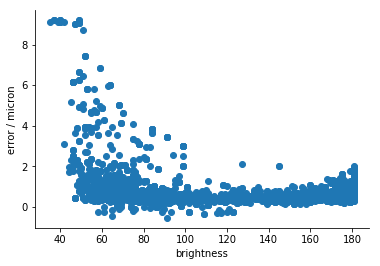

In [267]:
I.plt.plot(ppdf.intensity, ppdf.error, 'o')
I.plt.xlabel('brightness')
I.plt.ylabel('error / micron')
I.sns.despine()

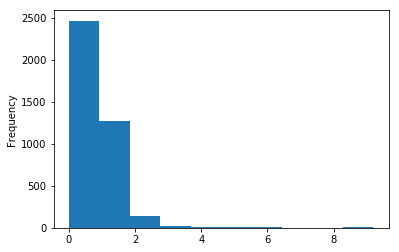

In [253]:
pdf[1].plot(kind='hist')

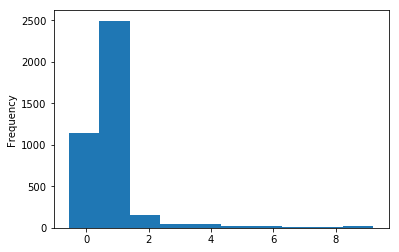

In [231]:
ppdf.error.plot(kind = 'hist')

(array([ 1144.,  2494.,   151.,    45.,    44.,    25.,    20.,     6.,
            4.,    21.]),
 array([-0.552 ,  0.4232,  1.3984,  2.3736,  3.3488,  4.324 ,  5.2992,
         6.2744,  7.2496,  8.2248,  9.2   ]),
 <a list of 10 Patch objects>)

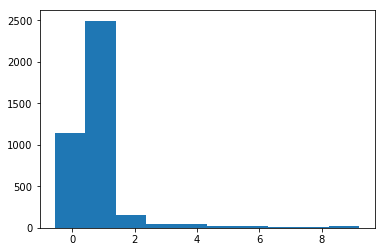

In [225]:
ppdf_selected = ppdf[ppdf.intensity > 0]
I.plt.hist(ppdf_selected[0]-ppdf_selected[2])

In [180]:
bins = I.np.arange(0,10,.1)
out = []
for intensity_cutoff in range(0,200,1):
    pdf_selected = pdf[pdf.intensity > intensity_cutoff]
    out.append(I.np.histogram(pdf_selected[0]-pdf_selected[2], bins = bins, normed = True)[0])

In [181]:
error_pdf = I.pd.DataFrame(out, index = range(0,200,1), columns = bins[:-1])
error_pdf.index.name = 'intensity_cutoff'
error_pdf = error_pdf.T
error_pdf.index.name = 'error / micron'
error_pdf = error_pdf.iloc[::-1]


In [182]:
%matplotlib inline

In [ ]:
postRadiiSet

In [150]:
len(radiiSet[0])

3954

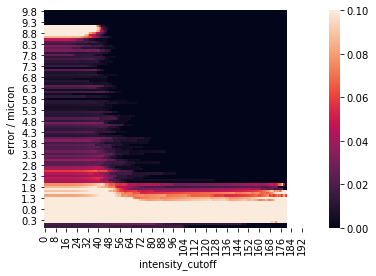

In [183]:
I.sns.heatmap(error_pdf, vmax=.1)

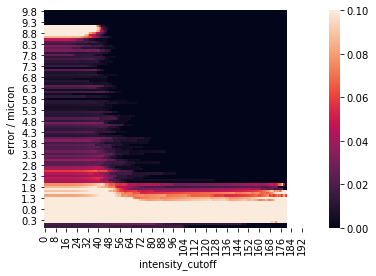

In [184]:
I.sns.heatmap(error_pdf, vmax=.1)

In [185]:
bins = I.np.arange(0,10,.1)
out = {}
for intensity_cutoff in range(0,200,1):
    pdf_selected = pdf[pdf.intensity > intensity_cutoff]
    out[intensity_cutoff] = len(pdf_selected) / float(len(pdf))

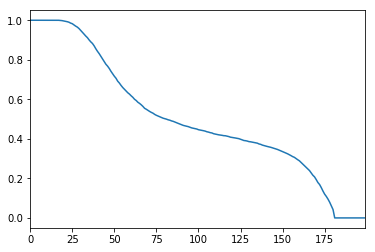

In [186]:
I.pd.Series(out).plot()

In [ ]:
out[50]

# For Amira Visualization

In [219]:
radi.spacialGraph.write_spacial_graph_with_thickness(inputAmData_s13, outputAmData025_s13, radiiSet[0])
radi.spacialGraph.write_spacial_graph_with_thickness(inputAmData_s13, outputAmData05_s13, postRadiiSet[1])
radi.spacialGraph.write_spacial_graph_with_thickness(inputAmData_s13, outputAmData075_s13, radiiSet[2])